# Set up Google Colab

This means mounting drive and importing

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install
#4/1AY0e-g5h4eZedG3k6mfdIj0OYbR717PFyEhKuxK5PidsrBbPRxi8fge6E3c

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net


In [ ]:
from model import *
from data import *

# Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.00,
                    height_shift_range=0.00,
                    shear_range=0.00,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/train','image','label',data_gen_args,save_to_dir = 'data/train/aug')
model = unet()
model_checkpoint = ModelCheckpoint('unet_grain.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 54 images belonging to 1 classes.
Found 54 images belonging to 1 classes.


### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

In [ ]:
%ls

data/              data.py  main.ipynb  model.py      README.md
dataPrepare.ipynb  LICENSE  main.py     __pycache__/  unet_grain.hdf5


### test your model and save predicted results

In [ ]:
testGene = testGenerator("data/test")
model = unet()
model.load_weights("unet_grain.hdf5")
results = 255 * model.predict_generator(testGene, 23, verbose=1)
saveResult("data/test", results.astype('uint8'))
# print(results.shape)
# io.imshow(results[22, :, :, 0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


23/23 [==============================] - 49s 454ms/step


# Small Post Processing Stage

This next thing is just to visualize what the processing is doing before applying it to all the images

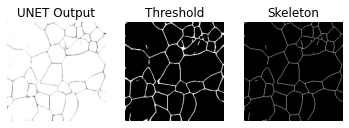

In [ ]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

post_process('data/test/0_predict.png', thresh=250, verbose=True)

#### This is to apply this processing to all the boundaries

In [ ]:
test_n = 23
test_dir = 'data/test/'

for i in range(test_n):
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=250)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

# Overlaying image